In [1]:
import tensorflow as tf
from keras import models,layers
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

I0000 00:00:1728837613.004656  106174 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728837613.185536  106174 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728837613.185811  106174 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)  # Set memory growth dynamically
#     except RuntimeError as e:
#         print(e)


In [4]:
# if gpus:
#     try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=512)]
#         )
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,",len(logical_gpus),"Logical GPUs")
#     except RuntimeError as e:
#         print(e)

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 5

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage/train",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,

)

# dataset = dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 3600 files belonging to 3 classes.


I0000 00:00:1728837613.360147  106174 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728837613.360433  106174 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728837613.360596  106174 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728837613.455822  106174 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
class_names = dataset.class_names

In [8]:
class_names

['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']

In [9]:
len(dataset)

450

In [10]:
# plt.figure(figsize=(20,20))
# for image_batch, label_batch in dataset.take(1):
#   for i in range(12):
#     ax = plt.subplot(3,4,i+1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(class_names[label_batch[i]])
#     plt.axis("off")
  # print(image_batch[0].numpy())
  # print(label_batch)

In [11]:
#80% training , 10% validation, 10% testing
# train_ds =  dataset.take(len(dataset)*0.8)
# val_and_train_ds = dataset.skip(len(dataset)*0.8)
# val_ds = val_and_train_ds.take(len(val_and_train_ds)*0.5)
# test_ds = val_and_train_ds.skip(len(val_and_train_ds)*0.5)


In [12]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    val_size = int( ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

360

In [15]:
len(val_ds)

45

In [16]:
len(test_ds)

45

In [17]:
# to load the next batch using cpu while the gpu does training
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
#The image given can be off different dimensions so we resize,
# the image has to be converted into grayscale so we rescale
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [19]:
# data augmentation is used, what is does is basically we have images, which we convert into it having horizontal flip, increased contrast, zoom and rotation
# Because we are not sure what device is used to capture the image in our app, it can have different processing done to give varying colors or orientation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [20]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Conv2D(64,(3,3),activation='relu'),
    # layers.MaxPooling2D((2,2)),
    # layers.Conv2D(64,(3,3),activation='relu'),
    # layers.MaxPooling2D((2,2)),
    # layers.Conv2D(64,(3,3),activation='relu'),
    # layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape);

/home/joywin-barboza/tf-gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (8, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (8, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (8, 254, 254, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (8, 127, 127, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 125, 125, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (8, 62, 62, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (8, 60, 60, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (8, 30, 30, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 57600)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 64)                │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,742,979 (14.28 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [23]:

# history = model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=val_ds,
# )
#****************************************************************

# class ClearSessionCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         tf.keras.backend.clear_session()

# # Fit the model with callbacks
# history = model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     verbose=1,
#     # batch_size=16,
#     # validation_data=val_ds,
#     callbacks=[ClearSessionCallback()]
# )


In [24]:
# model_version = 1
# model.save(f"../models/{model_version}.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


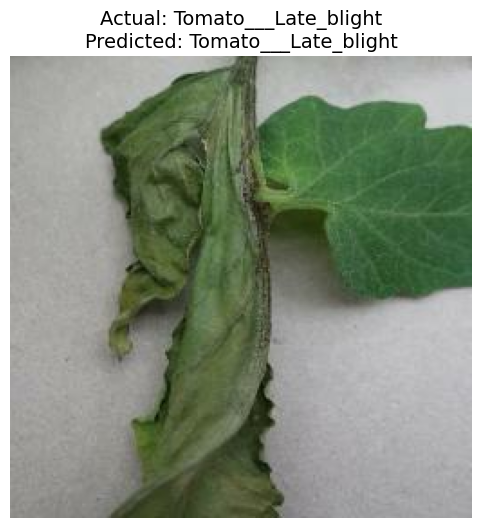

In [45]:
# import numpy as np
# for images_batch, labels_batch in test_ds.take(1):
#     first_image = images_batch[0].numpy().astype('uint8')
#     first_label = labels_batch[0].numpy()
    
#     print("First image to predict")
#     plt.imshow(first_image)
#     print("actual label:",class_names[first_label])
    
#     batch_prediction = model.predict(images_batch)
#     print("predicted labels:",class_names[np.argmax(batch_prediction[0])])

#***********************************8

# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from keras import models

# # Suppress TensorFlow logging
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only errors will be displayed

# # Step 1: Load the saved model
# model_path = '../models/1.keras'  # Adjust the path if you used a different extension
# model = models.load_model(model_path)

# # Step 2: Make predictions using the model
# for images_batch, labels_batch in test_ds.take(1):
#     first_image = images_batch[0].numpy().astype('uint8')
#     first_label = labels_batch[0].numpy()
    
#     print("First image to predict")
#     plt.imshow(first_image)
#     print("Actual label:", class_names[first_label])
    
#     # Get batch predictions
#     batch_prediction = model.predict(images_batch)
    
#     # Print predicted labels
#     predicted_label = np.argmax(batch_prediction[0])
#     print("Predicted label:", class_names[predicted_label])



#************************************************************************************************
import numpy as np
import matplotlib.pyplot as plt
from keras import models

# Load the saved model
model_path = '../models/1.keras'  # Adjust the path if you used a different extension
model = models.load_model(model_path)

# Make predictions using the model
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    # Get batch predictions
    batch_prediction = model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])
    
    # Create a subplot to display the image and labels
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.imshow(first_image)
    plt.axis('off')  # Hide axis

    # Add text for actual and predicted labels
    plt.title(f"Actual: {class_names[first_label]}\nPredicted: {class_names[predicted_label]}", fontsize=14)

    plt.show()
